torch.Size([100, 1, 28, 28]) torch.Size([100])


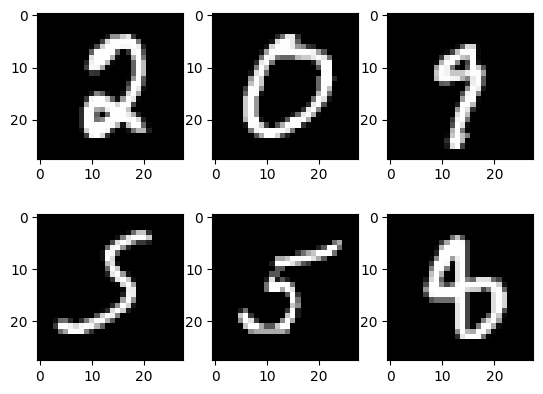

In [11]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import os

import sys
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter("_asset/runs/mnist2")

os.chdir('C:/Users/Errorwaf/Nutstore/1/我的坚果云/Obsidian/Knowledge Vault/Knowledge Vault/LLMStudy/PyTorch/实践案例')

# device config
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# hyper parameters
input_size = 28*28
hidden_size = 100
num_classes = 10
num_epochs = 2
batch_size = 100
learning_rate =0.001

# load MNIST
train_set = torchvision.datasets.MNIST(root='./_asset/data', train = True, transform = transforms.ToTensor(), download = True)
test_set = torchvision.datasets.MNIST(root='./_asset/data', train = False, transform = transforms.ToTensor(), download = True)

train_loader = torch.utils.data.DataLoader(dataset = train_set, batch_size = batch_size, shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset = test_set, batch_size = batch_size, shuffle = False)
examples = iter(train_loader)
samples, labels =next(examples)
print(samples.shape, labels.shape)

for i in range(6):
	plt.subplot(2,3,i+1)
	plt.imshow(samples[i][0], cmap = 'gray')
#plt.show()
img_grid = torchvision.utils.make_grid(samples)
writer.add_image('mnist_images', img_grid)
writer.close()


In [12]:
# 前馈网络


class NeuralNet(nn.Module):
	def __init__(self, input_size, hidden_size, num_classes):
		super(NeuralNet, self).__init__()
		self.l1 = nn.Linear(input_size, hidden_size)
		self.relu = nn.ReLU()
		self.l2 = nn.Linear(hidden_size, num_classes)
		
	def forward(self,x):
		out = self.l1(x)
		out = self.relu(out)
		out = self.l2(out)
		return out
	
model = NeuralNet(input_size, hidden_size, num_classes).to(device)

# 损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
writer.add_graph(model, samples.reshape(-1, 28*28).to(device))
writer.close()

In [13]:
# 训练
n_total_step = len(train_loader)

running_loss = 0.0
running_acc = 0

for epoch in range(num_epochs):
    for i, (images,labels) in enumerate(train_loader):
        # reshape image 100 1 28 28-> 100 784
        images = images.reshape(-1, 28*28).to(device)
        labels = labels.to(device)

        # forward
        output = model(images)
        loss = criterion(output, labels)

        #backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        running_acc += (torch.max(output.data,1)[1] == labels).sum().item()

        # process print
        if (i+1)%100==0:
            print(f'epoch {epoch+1}/{num_epochs}, step {i+1}/{n_total_step}, loss {loss.item()}')
            writer.add_scalar('training loss', running_loss/100, epoch*n_total_step+i)
            writer.add_scalar('training accuracy', running_acc/100, epoch*n_total_step+i)
            running_loss = 0.0
            running_acc =0.0


epoch 1/2, step 100/600, loss 0.4772180914878845
epoch 1/2, step 200/600, loss 0.23006008565425873
epoch 1/2, step 300/600, loss 0.3230046033859253
epoch 1/2, step 400/600, loss 0.21229901909828186
epoch 1/2, step 500/600, loss 0.259697288274765
epoch 1/2, step 600/600, loss 0.2111291140317917
epoch 2/2, step 100/600, loss 0.18159279227256775
epoch 2/2, step 200/600, loss 0.30199944972991943
epoch 2/2, step 300/600, loss 0.23634767532348633
epoch 2/2, step 400/600, loss 0.18028724193572998
epoch 2/2, step 500/600, loss 0.13040095567703247
epoch 2/2, step 600/600, loss 0.11471238732337952


In [15]:
# 测试
labs = []
preds = []

with torch.no_grad():
	n_correct = 0
	n_samples = 0
	for images,labels in test_loader:
		images = images.reshape(-1, 28*28).to(device)
		labels = labels.to(device)
		outputs = model(images)
		
		#value, index = torch.max()
		_, predictions = torch.max(outputs,1)
		n_samples += labels.shape[0]
		n_correct += (predictions == labels).sum().item()

		class_predictions = [F.softmax(output, dim=0) for output in outputs]

		preds.append(class_predictions)
		labs.append(predictions)

	preds = torch.cat([torch.stack(batch) for batch in preds])
	labs = torch.cat(labs)
	acc = 100*n_correct/n_samples
	print(f'accuracy = {acc}')
	classes = range(10)
	for i in classes:
		labs_i = labs == i
		preds_i = preds[:, i]
		writer.add_pr_curve(str(i), labs_i, preds_i, global_step=0)
		writer.close()


accuracy = 95.37
